In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [2]:
df_raw = pd.read_excel('C:\\Users\\DELL\\Downloads\\GSE7553.XLSX', sheet_name='Sheet1')

In [3]:
print("Checking missing values:")
print(df_raw.isnull().sum())

Checking missing values:
!Sample_characteristics_ch1    0
Basal cell carcinoma           0
Basal cell carcinoma.1         0
Basal cell carcinoma.2         0
Basal cell carcinoma.3         0
                              ..
Normal Skin.1                  0
Normal Skin.2                  0
Normal Skin.3                  0
Primary Melanoma.12            0
Primary Melanoma.13            0
Length: 88, dtype: int64


In [4]:
df_raw = df_raw.set_index(df_raw.columns[0])

In [5]:
sample_labels = df_raw.columns
y_raw = [label.split('.')[0] for label in sample_labels]

In [6]:
df_transposed = df_raw.transpose()

In [7]:
X = df_transposed.astype(float).values

In [8]:
print("Unique labels:", set(y_raw))

Unique labels: {'Basal cell carcinoma', 'Metastatic Melanoma', 'Primary Melanoma', 'Normal Skin', 'Melanoma in situ', 'normal human epidermal melanocytes', 'Squamous cell carcinoma'}


In [9]:
encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
y_encoded = to_categorical(y)
num_classes = len(encoder.classes_) 

  Basal cell carcinoma: 15 samples
  Melanoma in situ: 2 samples
  Metastatic Melanoma: 40 samples
  Normal Skin: 4 samples
  Primary Melanoma: 14 samples
  Squamous cell carcinoma: 11 samples
  normal human epidermal melanocytes: 1 samples


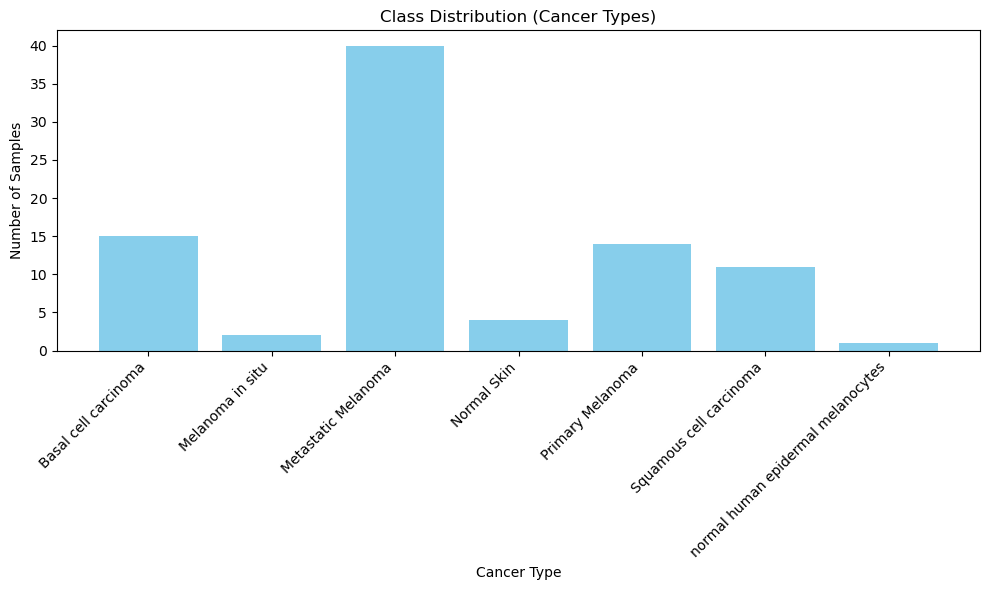

In [10]:
unique, counts = np.unique(y, return_counts=True)

for cls, count in zip(encoder.classes_, counts):
    print(f"  {cls}: {count} samples")

plt.figure(figsize=(10, 6))
plt.bar(encoder.classes_, counts, color='skyblue')
plt.title('Class Distribution (Cancer Types)')
plt.xlabel('Cancer Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [13]:
print(X_train.shape)

(69, 54675)


In [21]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [23]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.6954 - accuracy: 0.2754
Epoch 1: val_loss improved from inf to 2.40246, saving model to best_model.h5
9/9 [==============================] - 5s 376ms/step - loss: 2.6954 - accuracy: 0.2754 - val_loss: 2.4025 - val_accuracy: 0.7778
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.1332 - accuracy: 0.6667
Epoch 2: val_loss improved from 2.40246 to 2.10188, saving model to best_model.h5
9/9 [==============================] - 2s 292ms/step - loss: 1.1332 - accuracy: 0.6667 - val_loss: 2.1019 - val_accuracy: 0.7778
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.9783 - accuracy: 0.6812
Epoch 3: val_loss improved from 2.10188 to 1.70620, saving model to best_model.h5
9/9 [==============================] - 2s 276ms/step - loss: 0.9783 - accuracy: 0.6812 - val_loss: 1.7062 - val_accuracy: 0.7778
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.7101
Epo

Epoch 30/50
9/9 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9710
Epoch 30: val_loss did not improve from 0.38772
9/9 [==============================] - 1s 116ms/step - loss: 0.1078 - accuracy: 0.9710 - val_loss: 0.4496 - val_accuracy: 0.8333
Epoch 31/50
9/9 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.8841
Epoch 31: val_loss did not improve from 0.38772
9/9 [==============================] - 1s 120ms/step - loss: 0.4390 - accuracy: 0.8841 - val_loss: 0.4804 - val_accuracy: 0.7778
Epoch 32/50
9/9 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9130
Epoch 32: val_loss did not improve from 0.38772
9/9 [==============================] - 1s 114ms/step - loss: 0.2423 - accuracy: 0.9130 - val_loss: 0.4457 - val_accuracy: 0.8889
Epoch 33/50
9/9 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9420
Epoch 33: val_loss did not improve from 0.38772
9/9 [==============================] - 1s 120ms/s

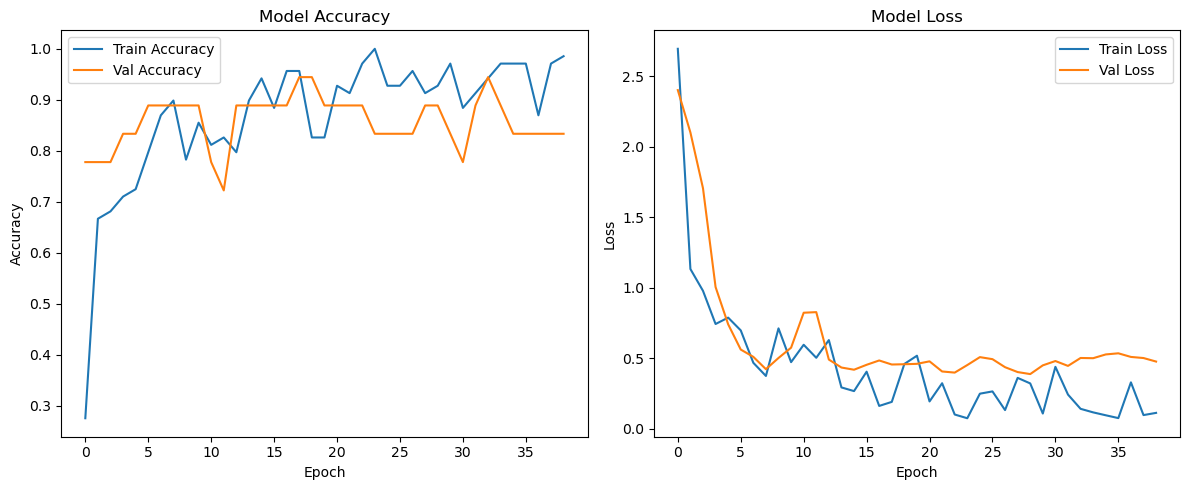

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import classification_report

all_class_indices = list(range(len(encoder.classes_)))

print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred,
                            labels=all_class_indices,
                            target_names=encoder.classes_))



Classification Report:
                                    precision    recall  f1-score   support

              Basal cell carcinoma       1.00      1.00      1.00         3
                  Melanoma in situ       0.00      0.00      0.00         1
               Metastatic Melanoma       1.00      1.00      1.00         9
                       Normal Skin       1.00      0.50      0.67         2
                  Primary Melanoma       0.00      0.00      0.00         0
           Squamous cell carcinoma       0.75      1.00      0.86         3
normal human epidermal melanocytes       0.00      0.00      0.00         0

                          accuracy                           0.89        18
                         macro avg       0.54      0.50      0.50        18
                      weighted avg       0.90      0.89      0.88        18



C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sk

In [29]:
print(classification_report(y_val_true, y_val_pred,
                            labels=all_class_indices,
                            target_names=encoder.classes_,
                            zero_division=0))

                                    precision    recall  f1-score   support

              Basal cell carcinoma       1.00      1.00      1.00         3
                  Melanoma in situ       0.00      0.00      0.00         1
               Metastatic Melanoma       1.00      1.00      1.00         9
                       Normal Skin       1.00      0.50      0.67         2
                  Primary Melanoma       0.00      0.00      0.00         0
           Squamous cell carcinoma       0.75      1.00      0.86         3
normal human epidermal melanocytes       0.00      0.00      0.00         0

                          accuracy                           0.89        18
                         macro avg       0.54      0.50      0.50        18
                      weighted avg       0.90      0.89      0.88        18



In [18]:
df_test = pd.read_excel('C:\\Users\\DELL\\Downloads\\GSE7553.XLSX', sheet_name='Sheet1', index_col=0)
df_test = df_test.loc[df_raw.index]

In [19]:
X_test = df_test.transpose().astype(float).values
X_test_scaled = scaler.transform(X_test)

In [20]:
print("\n--- Predict One Sample at a Time ---")
print("Available sample indices: 0 to", X_test_scaled.shape[0] - 1)
print("Enter 'exit' to quit.\n")

while True:
    user_input = input("Enter sample number to predict (e.g., 0): ")
    if user_input.lower() == 'exit':
        print("Exiting prediction loop.")
        break
    if not user_input.isdigit():
        print("Invalid input. Please enter a number.")
        continue
    index = int(user_input)
    if index < 0 or index >= X_test_scaled.shape[0]:
        print(f"Index out of range. Please enter 0 to {X_test_scaled.shape[0] - 1}.")
        continue

    sample = X_test_scaled[index:index+1]
    pred_prob = model.predict(sample)
    pred_class = np.argmax(pred_prob)
    pred_label = encoder.inverse_transform([pred_class])[0]
    print(f"Sample {index}: Predicted Cancer Type -> {pred_label}\n")


--- Predict One Sample at a Time ---
Available sample indices: 0 to 86
Enter 'exit' to quit.

Enter sample number to predict (e.g., 0): 1
1/1 [==============================] - 0s 400ms/step
Sample 1: Predicted Cancer Type -> Basal cell carcinoma

Enter sample number to predict (e.g., 0): 2
1/1 [==============================] - 0s 77ms/step
Sample 2: Predicted Cancer Type -> Basal cell carcinoma

Enter sample number to predict (e.g., 0): 3
1/1 [==============================] - 0s 70ms/step
Sample 3: Predicted Cancer Type -> Basal cell carcinoma

Enter sample number to predict (e.g., 0): 
Invalid input. Please enter a number.
Enter sample number to predict (e.g., 0): 4
1/1 [==============================] - 0s 78ms/step
Sample 4: Predicted Cancer Type -> Squamous cell carcinoma

Enter sample number to predict (e.g., 0): 5
1/1 [==============================] - 0s 75ms/step
Sample 5: Predicted Cancer Type -> Melanoma in situ

Enter sample number to predict (e.g., 0): 8
1/1 [==========